### **Data Understanding**

In [1]:
import pandas as pd
df = pd.read_csv('/content/daily_data.csv')
df.head()

,day_id,city_id,temperature_celsius,condition_text,wind_kph,wind_degree,pressure_mb,precip_mm,humidity,cloud,feels_like_celsius,visibility_km,uv_index,gust_kph,air_quality_us-epa-index,sunrise,sunset
0,D0001,C001,27.0,NaN,6.1,210,1006.0,0.0,54,75,28.0,10.0,6.0,11.9,2,06:04 AM,07:19 PM
1,D0002,C001,22.0,NaN,6.1,170,1006.0,0.0,73,75,24.5,10.0,1.0,23.4,1,06:05 AM,07:18 PM
2,D0003,C001,20.0,Light Rain with Thunder,3.6,10,1011.0,4.5,100,75,20.0,10.0,1.0,12.6,1,06:05 AM,07:18 PM
3,D0004,C001,17.0,Clear and Sunny,6.1,150,1018.0,0.0,88,0,17.0,10.0,1.0,11.2,1,06:06 AM,07:16 PM
4,D0005,C001,18.0,NaN,3.6,92,1019.0,0.0,94,0,18.0,10.0,1.0,9.0,1,06:07 AM,07:15 PM


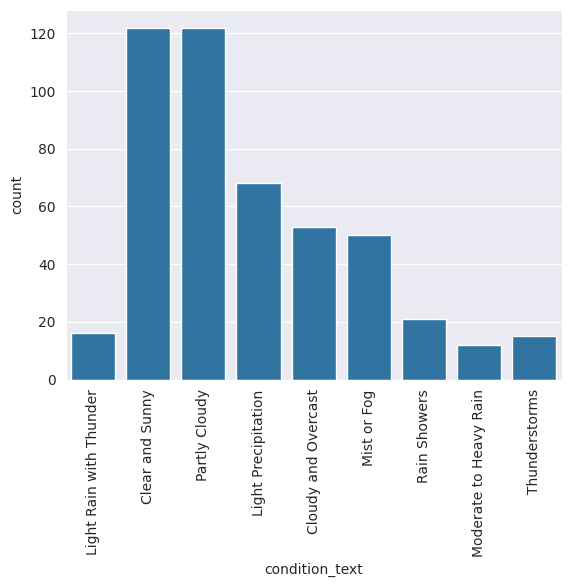

In [4]:
df_non_null = df.dropna(subset=['condition_text'])
sns.countplot(x='condition_text',data=df_non_null)
plt.xticks(rotation=90)
plt.show()

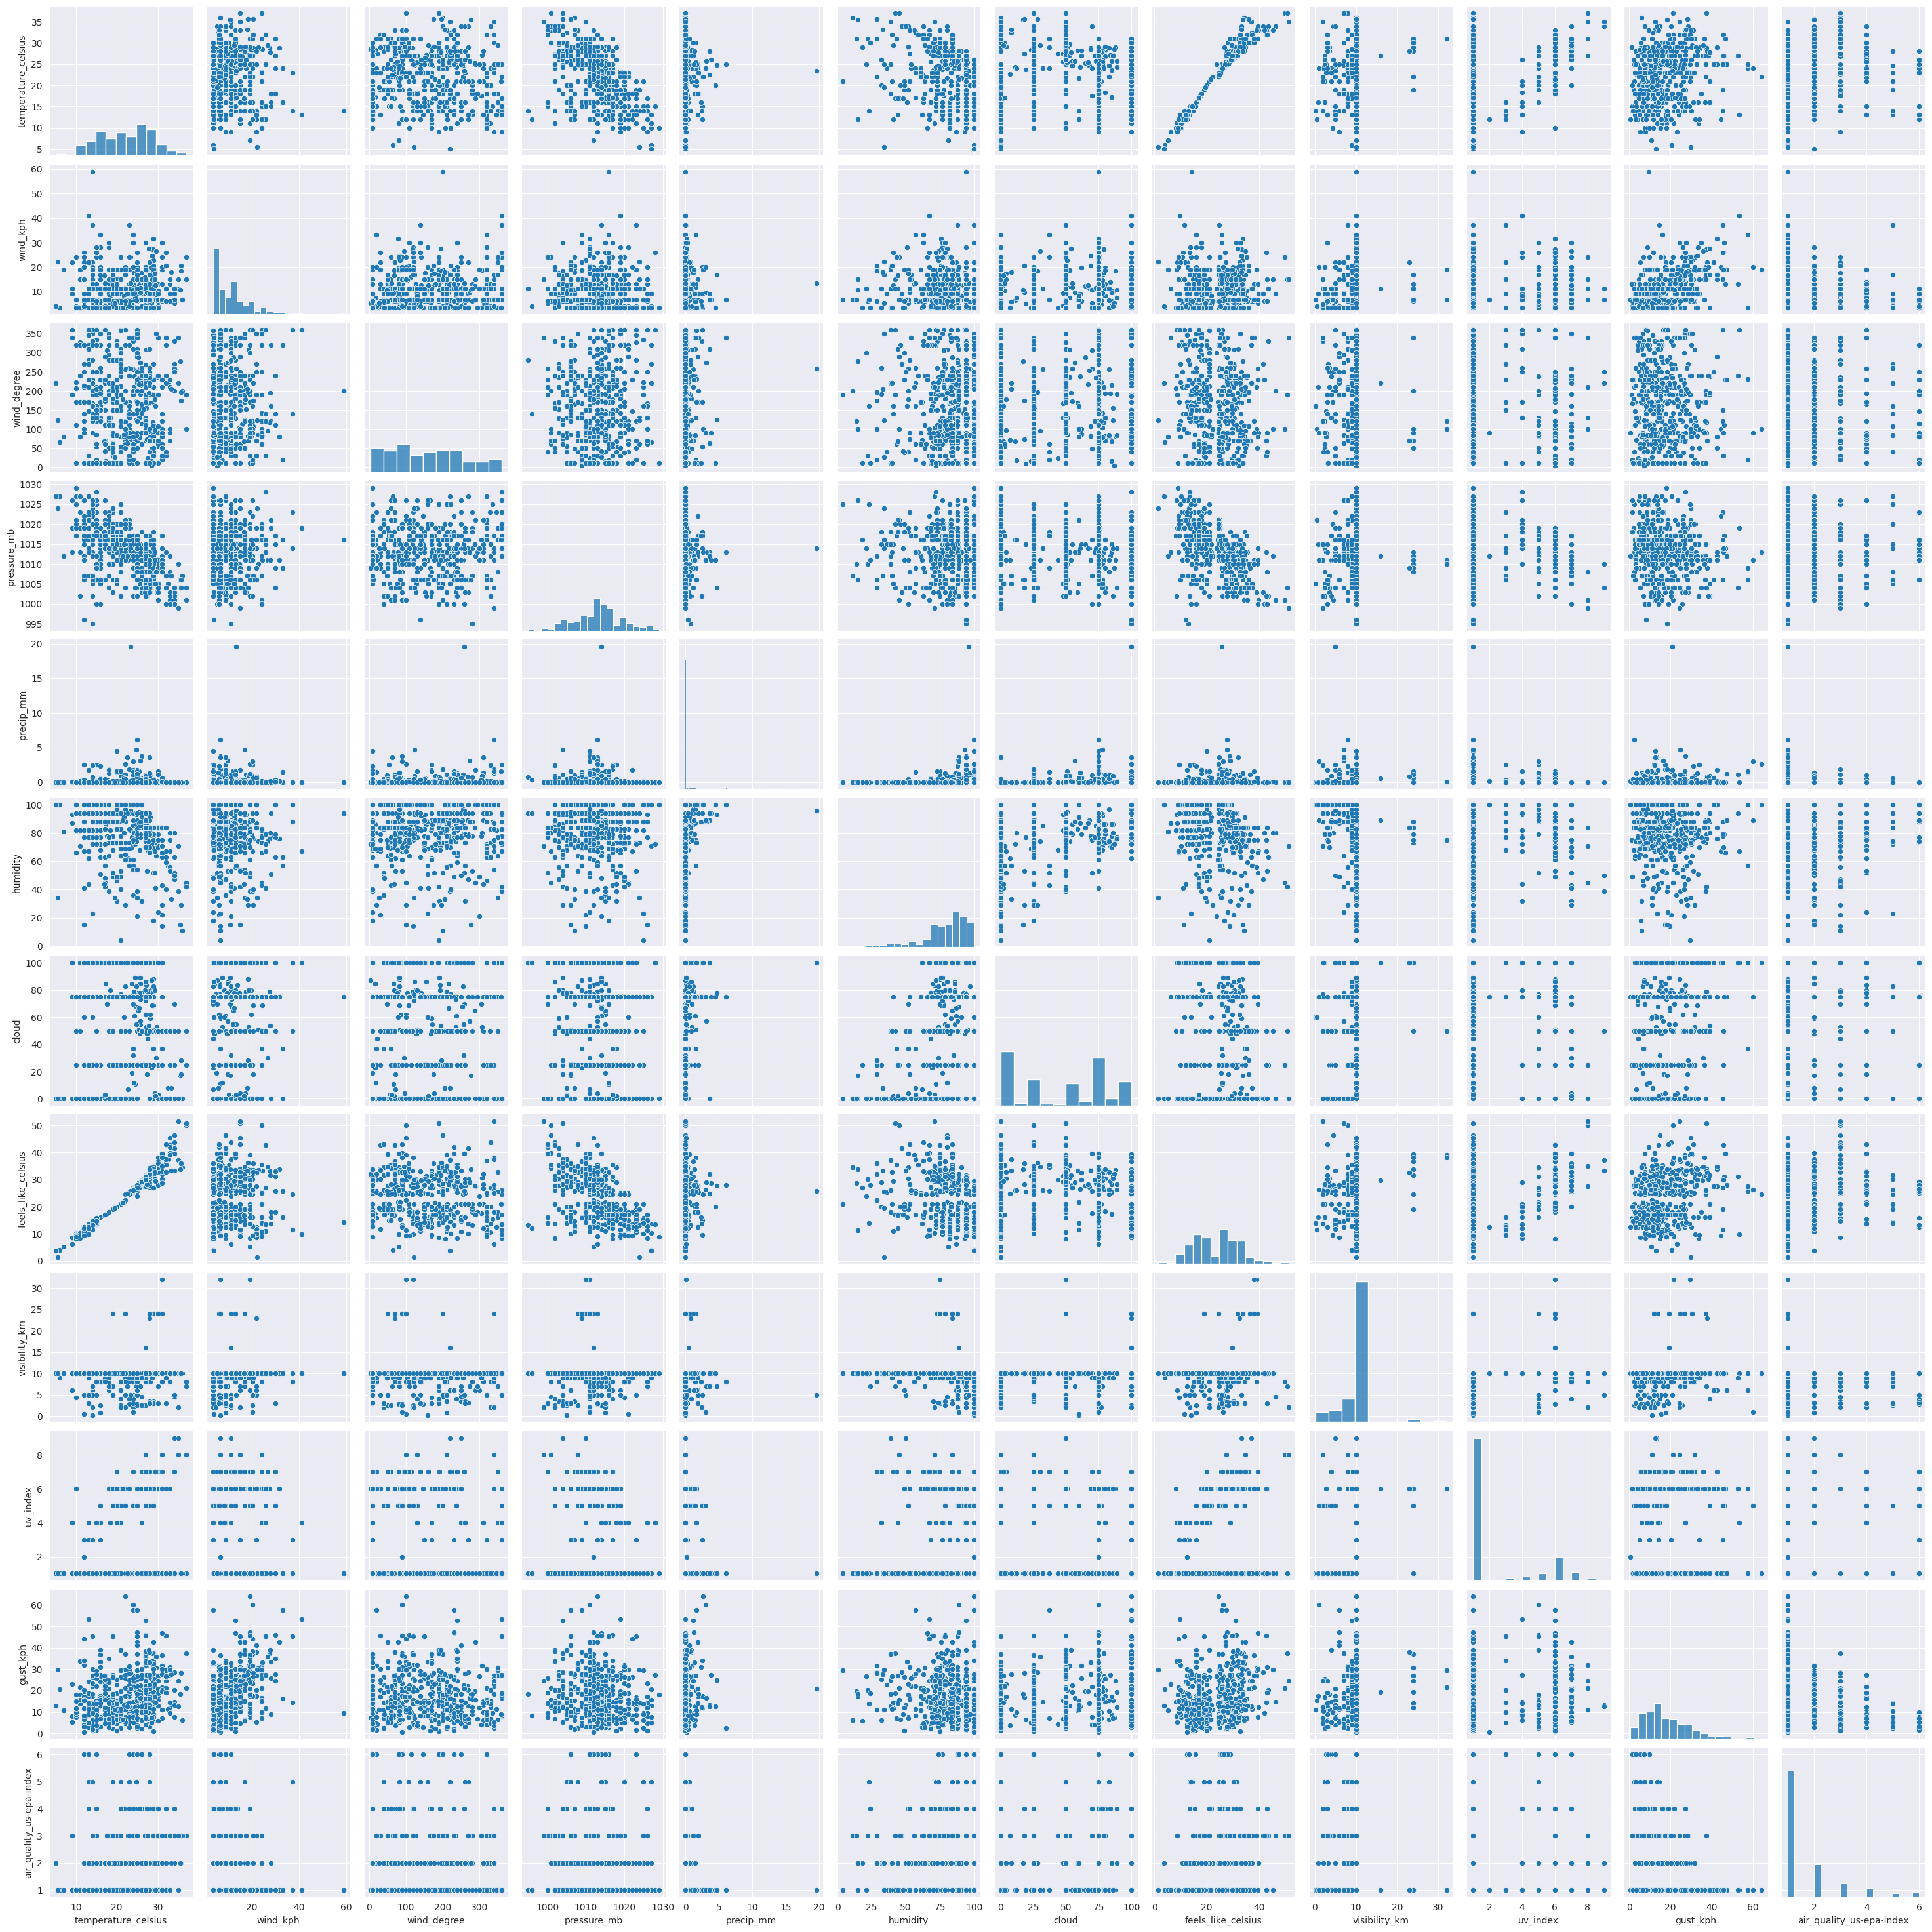

In [5]:
sns.pairplot(df_non_null)


### **Data Preprocessing**

In [6]:
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report, accuracy_score
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier

# Load the dataset
file_path = '/content/daily_data.csv'
df = pd.read_csv(file_path)

# Drop rows with missing target values
non_null_df = df.dropna(subset=['condition_text'])

# Encode the target variable
le = LabelEncoder()
non_null_df['condition_text_encoded'] = le.fit_transform(non_null_df['condition_text'])

# Define features and target
features = [
    'temperature_celsius', 'wind_kph', 'pressure_mb', 'precip_mm', 'humidity',
    'cloud', 'feels_like_celsius', 'visibility_km', 'uv_index', 'gust_kph', 'air_quality_us-epa-index'
]

# Add custom features based on observations
non_null_df['low_precip'] = non_null_df['precip_mm'] * (non_null_df['condition_text'] == 'Light Precipitation').astype(int)
non_null_df['high_wind_degree'] = non_null_df['wind_degree'] * (non_null_df['condition_text'] == 'Rain Showers').astype(int)
non_null_df['low_visibility'] = non_null_df['visibility_km'] * (non_null_df['condition_text'] == 'Mist or Fog').astype(int)
non_null_df['new_gust'] = non_null_df['gust_kph'] * (non_null_df['condition_text'] == 'Thunderstorms').astype(int)

# Include these new features
features.extend(['low_precip', 'high_wind_degree', 'low_visibility', 'new_gust'])

X = non_null_df[features]
y = non_null_df['condition_text_encoded']

# Apply SMOTE to handle class imbalance
SMT = SMOTE(random_state=42)
X_resample, y_resample = SMT.fit_resample(X, y)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_resample, y_resample, test_size=0.2, random_state=42)

# Standardize the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Get class weights
class_weights = dict(zip(range(len(le.classes_)), [1.0] * len(le.classes_)))
class_weights[le.transform(['Light Precipitation'])[0]] = 5.0  # Increase the weight for 'Light Precipitation'

# Train the XGBoost model with class weights
best_xgb = XGBClassifier(
    n_estimators=300,
    max_depth=10,
    learning_rate=0.05,
    colsample_bytree=0.7,
    reg_alpha=0.01,
    reg_lambda=0.01,
    random_state=42,
    eval_metric='mlogloss',
    scale_pos_weight=class_weights
)
best_xgb.fit(X_train_scaled, y_train)

# Predict the target on the test set
y_pred_xgb = best_xgb.predict(X_test_scaled)

# Evaluate the XGBoost model
classification_report_str = classification_report(y_test, y_pred_xgb, target_names=le.classes_)
accuracy_xgb = accuracy_score(y_test, y_pred_xgb)

print("Classification Report:\n", classification_report_str)
print(f"Accuracy: {accuracy_xgb:.2f}")

from sklearn.model_selection import cross_val_score

# Temporarily disable early stopping for cross-validation
best_xgb.set_params(early_stopping_rounds=None)

cv_scores = cross_val_score(best_xgb, X_train_scaled, y_train, cv=5)
print(f"Cross-validation scores: {cv_scores}")
print(f"Mean CV score: {cv_scores.mean()}")

# Now use the model to predict the missing condition_text values in the original dataframe
missing_df = df[df['condition_text'].isna()]

# Apply the same feature engineering to the missing_df
missing_df['low_precip'] = missing_df['precip_mm'] * (missing_df['condition_text'] == 'Light Precipitation').astype(int)
missing_df['high_wind_degree'] = missing_df['wind_degree'] * (missing_df['condition_text'] == 'Rain Showers').astype(int)
missing_df['low_visibility'] = missing_df['visibility_km'] * (missing_df['condition_text'] == 'Mist or Fog').astype(int)
missing_df['new_gust'] = missing_df['gust_kph'] * (missing_df['condition_text'] == 'Thunderstorms').astype(int)

# Include these new features in the same way as the training set
missing_X = missing_df[features]
missing_X_scaled = scaler.transform(missing_X)

# Predict missing values
missing_predictions = best_xgb.predict(missing_X_scaled)
missing_df['condition_text'] = le.inverse_transform(missing_predictions)

# Fill the missing values in the original dataframe
df.loc[df['condition_text'].isna(), 'condition_text'] = missing_df['condition_text']

# Create a new dataframe with day_id and condition_text
submission_df = df[['day_id', 'condition_text']]

# Save the new dataframe to a CSV file
submission_file_path = '/content/submission.csv'
submission_df.to_csv(submission_file_path, index=False)

print(f"Submission file saved to: {submission_file_path}")


<ipython-input-6-340f15a08bee>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  non_null_df['condition_text_encoded'] = le.fit_transform(non_null_df['condition_text'])
<ipython-input-6-340f15a08bee>:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  non_null_df['low_precip'] = non_null_df['precip_mm'] * (non_null_df['condition_text'] == 'Light Precipitation').astype(int)
<ipython-input-6-340f15a08bee>:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .

Classification Report:
                          precision    recall  f1-score   support

        Clear and Sunny       1.00      1.00      1.00        32
    Cloudy and Overcast       1.00      0.96      0.98        26
    Light Precipitation       0.96      0.88      0.92        26
Light Rain with Thunder       0.90      1.00      0.95        18
            Mist or Fog       1.00      1.00      1.00        30
 Moderate to Heavy Rain       0.96      1.00      0.98        22
          Partly Cloudy       0.82      0.86      0.84        21
           Rain Showers       1.00      1.00      1.00        23
          Thunderstorms       1.00      0.95      0.98        22

               accuracy                           0.96       220
              macro avg       0.96      0.96      0.96       220
           weighted avg       0.97      0.96      0.96       220

Accuracy: 0.96


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [21:20:20] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [21:20:21] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [21:20:22] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [21:20:23] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [21:20:25] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "scale_pos_weigh

Cross-validation scores: [0.9375     0.93181818 0.90909091 0.96571429 0.94857143]
Mean CV score: 0.9385389610389611
Submission file saved to: /content/submission.csv


<ipython-input-6-340f15a08bee>:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  missing_df['low_precip'] = missing_df['precip_mm'] * (missing_df['condition_text'] == 'Light Precipitation').astype(int)
<ipython-input-6-340f15a08bee>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  missing_df['high_wind_degree'] = missing_df['wind_degree'] * (missing_df['condition_text'] == 'Rain Showers').astype(int)
<ipython-input-6-340f15a08bee>:93: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slic

### **Train Test Spliting and add class weight **

In [7]:
X = non_null_df[features]
y = non_null_df['condition_text_encoded']

# Apply SMOTE to handle class imbalance
SMT = SMOTE(random_state=42)
X_resample, y_resample = SMT.fit_resample(X, y)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_resample, y_resample, test_size=0.2, random_state=42)

# Standardize the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Get class weights
class_weights = dict(zip(range(len(le.classes_)), [1.0] * len(le.classes_)))
class_weights[le.transform(['Light Precipitation'])[0]] = 5.0  # Increase the weight for 'Light Precipitation'



### **Train model**

In [8]:
# Train the XGBoost model with class weights
best_xgb = XGBClassifier(
    n_estimators=300,
    max_depth=10,
    learning_rate=0.05,
    colsample_bytree=0.7,
    reg_alpha=0.01,
    reg_lambda=0.01,
    random_state=42,
    eval_metric='mlogloss',
    scale_pos_weight=class_weights
)
best_xgb.fit(X_train_scaled, y_train)



/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [21:20:28] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.7, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.05, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=10,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=300,
              n_jobs=None, num_parallel_tree=None, objective='multi:softprob', ...)

### **Predict model and Evaluate model**

In [9]:
# Predict the target on the test set
y_pred_xgb = best_xgb.predict(X_test_scaled)

# Evaluate the XGBoost model
classification_report_str = classification_report(y_test, y_pred_xgb, target_names=le.classes_)
accuracy_xgb = accuracy_score(y_test, y_pred_xgb)

print("Classification Report:\n", classification_report_str)
print(f"Accuracy: {accuracy_xgb:.2f}")

from sklearn.model_selection import cross_val_score

# Temporarily disable early stopping for cross-validation
best_xgb.set_params(early_stopping_rounds=None)

cv_scores = cross_val_score(best_xgb, X_train_scaled, y_train, cv=5)
print(f"Cross-validation scores: {cv_scores}")
print(f"Mean CV score: {cv_scores.mean()}")



Classification Report:
                          precision    recall  f1-score   support

        Clear and Sunny       1.00      1.00      1.00        32
    Cloudy and Overcast       1.00      0.96      0.98        26
    Light Precipitation       0.96      0.88      0.92        26
Light Rain with Thunder       0.90      1.00      0.95        18
            Mist or Fog       1.00      1.00      1.00        30
 Moderate to Heavy Rain       0.96      1.00      0.98        22
          Partly Cloudy       0.82      0.86      0.84        21
           Rain Showers       1.00      1.00      1.00        23
          Thunderstorms       1.00      0.95      0.98        22

               accuracy                           0.96       220
              macro avg       0.96      0.96      0.96       220
           weighted avg       0.97      0.96      0.96       220

Accuracy: 0.96


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [21:20:32] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [21:20:33] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [21:20:34] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [21:20:35] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [21:20:38] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "scale_pos_weigh

Cross-validation scores: [0.9375     0.93181818 0.90909091 0.96571429 0.94857143]
Mean CV score: 0.9385389610389611


### **use the model to predict the missing condition_text values in the original dataframe**

In [11]:
# Now use the model to predict the missing condition_text values in the original dataframe
# Check if there are actually any missing values before proceeding
if df['condition_text'].isna().sum() > 0:
    missing_df = df[df['condition_text'].isna()]

    # Apply the same feature engineering to the missing_df
    missing_df['low_precip'] = missing_df['precip_mm'] * (missing_df['condition_text'] == 'Light Precipitation').astype(int)
    missing_df['high_wind_degree'] = missing_df['wind_degree'] * (missing_df['condition_text'] == 'Rain Showers').astype(int)
    missing_df['low_visibility'] = missing_df['visibility_km'] * (missing_df['condition_text'] == 'Mist or Fog').astype(int)
    missing_df['new_gust'] = missing_df['gust_kph'] * (missing_df['condition_text'] == 'Thunderstorms').astype(int)

    # Include these new features in the same way as the training set
    missing_X = missing_df[features]
    missing_X_scaled = scaler.transform(missing_X)

    # Predict missing values
    missing_predictions = best_xgb.predict(missing_X_scaled)
    missing_df['condition_text'] = le.inverse_transform(missing_predictions)

    # Fill the missing values in the original dataframe
    df.loc[df['condition_text'].isna(), 'condition_text'] = missing_df['condition_text']
else:
    print("No missing values in 'condition_text' column.")

# Create a new dataframe with day_id and condition_text
submission_df = df[['day_id', 'condition_text']]

# Save the new dataframe to a CSV file
submission_file_path = '/content/submission.csv'
submission_df.to_csv(submission_file_path, index=False)

print(f"Submission file saved to: {submission_file_path}")

No missing values in 'condition_text' column.
Submission file saved to: /content/submission.csv
